In [ ]:
import csv
import pandas as pd
from functools import reduce
from google.colab import files
from talib import MA_Type
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 13.2MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp36-cp36m-linux_x86_64.whl size=1437820 sha256=5f87c3f34b1a08ee8fd244d455355e6ab81c10b3a81d277f12a8e838a4975184
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


# **START HERE** 

In [ ]:
uploaded = files.upload()
data_brljpy=pd.read_excel('BRLJPYNT.xlsx')

Saving BRLJPYNT.xlsx to BRLJPYNT.xlsx


In [ ]:
uploaded = files.upload()
data_seknok=pd.read_excel('SEKNOKNT.xlsx')

Saving SEKNOKNT.xlsx to SEKNOKNT.xlsx


In [ ]:
data_brljpy = data_brljpy.rename(columns={data_brljpy.columns[0]: 'date'})
data_seknok = data_seknok.rename(columns={data_seknok.columns[0]: 'date'})
data_brljpy_n10y = data_brljpy.drop('brl_10y_gov',axis=1)
data_brjp = data_brljpy_n10y.dropna()
data_swnw = data_seknok.dropna()

In [ ]:
data_brjp['date'] = pd.to_datetime(data_brjp['date'], format='%Y-%m-%d')
data_swnw['date'] = pd.to_datetime(data_swnw['date'], format='%Y-%m-%d')
data_brjp = data_brjp.set_index('date')
data_swnw = data_swnw.set_index('date')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#data_brjp_rev = data_brjp.reindex(index=data_brjp.index[::-1])
data_brjp_rev = data_brjp[::-1]
#data_brjp_rev=data_brjp_rev.drop(['CHG_NET_1D','ibovespa_p','ibovespa_vol','brl_ir','jpy_libor','nikkei_p','nikkei_vol'],axis=1)
data_swnw_rev = data_swnw[::-1]

In [ ]:
data_swnw_rev.describe()

,PX_LAST,PX_BID,PX_ASK,PX_MID,PX_LOW,PX_HIGH,CHG_NET_1D,omx30_p,omx30_vol,sek_ir,oseax_p,oseax_vol,nok_ir
count,4906.000000,4906.000000,4906.000000,4906.000000,4906.000000,4906.000000,4906.000000,4906.000000,4.906000e+03,4906.000000,4906.000000,4.906000e+03,4906.000000
mean,0.897974,0.896916,0.899039,0.897974,0.894324,0.901626,0.000043,1132.363511,1.528940e+08,1.551097,518.141844,1.812014e+08,2.678443
std,0.059896,0.059509,0.060301,0.059897,0.059383,0.060602,0.004483,359.883073,1.053268e+08,1.691860,257.592805,1.176773e+08,1.978872
min,0.763200,0.761900,0.764400,0.763180,0.758600,0.770100,-0.035200,421.010000,1.213361e+07,-0.778000,105.820000,1.522700e+07,0.080000
25%,0.850725,0.850000,0.851425,0.850728,0.848000,0.853600,-0.002500,851.967500,8.650016e+07,-0.061750,330.565500,1.109851e+08,1.370000
50%,0.896000,0.895300,0.896850,0.896005,0.892900,0.899300,0.000000,1093.904500,1.171973e+08,1.395000,488.418500,1.588044e+08,1.990000
75%,0.932250,0.930975,0.933600,0.932252,0.928800,0.936275,0.002300,1453.813500,1.936127e+08,2.842000,675.752500,2.252992e+08,3.140000
max,1.128600,1.112800,1.156800,1.128620,1.087600,1.169000,0.048600,1926.471000,2.346316e+09,5.440000,1079.150000,2.165845e+09,9.130000


In [ ]:
adf_test_last = adfuller(data_brjp_rev['PX_LAST'])
adf_test_bid = adfuller(data_brjp_rev['PX_BID'])
adf_test_ask = adfuller(data_brjp_rev['PX_ASK'])
adf_test_mid = adfuller(data_brjp_rev['PX_MID'])
adf_test_low = adfuller(data_brjp_rev['PX_LOW'])
adf_test_high = adfuller(data_brjp_rev['PX_HIGH'])
adf_test_pct_change = adfuller(data_brjp_rev['CHG_NET_1D'])
adf_test_ibovespa_p = adfuller(data_brjp_rev['ibovespa_p'])
adf_test_ibovespa_vol = adfuller(data_brjp_rev['ibovespa_vol'])
adf_test_brl_ir = adfuller(data_brjp_rev['brl_ir'])
adf_test_jpy_libor = adfuller(data_brjp_rev['jpy_libor'])
adf_test_nikkei_p = adfuller(data_brjp_rev['nikkei_p'])
adf_test_nikkei_vol = adfuller(data_brjp_rev['nikkei_vol'])

print('---------------------------------last')
print ("ADF = " + str(adf_test_last[0]))
print ("p-value = " +str(adf_test_last[1]))
print('---------------------------------bid')
print ("ADF = " + str(adf_test_bid[0]))
print ("p-value = " +str(adf_test_bid[1]))
print('---------------------------------ask')
print ("ADF = " + str(adf_test_ask[0]))
print ("p-value = " +str(adf_test_ask[1]))
print('---------------------------------mid')
print ("ADF = " + str(adf_test_mid[0]))
print ("p-value = " +str(adf_test_mid[1]))
print('---------------------------------low')
print ("ADF = " + str(adf_test_low[0]))
print ("p-value = " +str(adf_test_low[1]))
print('--------------------------------high')
print ("ADF = " + str(adf_test_high[0]))
print ("p-value = " +str(adf_test_high[1]))
print('--------------------------pct_change')
print ("ADF = " + str(adf_test_pct_change[0]))
print ("p-value = " +str(adf_test_pct_change[1]))
print('--------------------------------ibovespa_p')
print ("ADF = " + str(adf_test_ibovespa_p[0]))
print ("p-value = " +str(adf_test_ibovespa_p[1]))
print('------------------------------ibovespa_vol')
print ("ADF = " + str(adf_test_ibovespa_vol[0]))
print ("p-value = " +str(adf_test_ibovespa_vol[1]))
print('----------------------------brl_ir')
print ("ADF = " + str(adf_test_brl_ir[0]))
print ("p-value = " +str(adf_test_brl_ir[1]))
print('-------------------------------jpy_libor')
print ("ADF = " + str(adf_test_jpy_libor[0]))
print ("p-value = " +str(adf_test_jpy_libor[1]))
print('-----------------------------nikkei_p')
print ("ADF = " + str(adf_test_nikkei_p[0]))
print ("p-value = " +str(adf_test_nikkei_p[1]))
print('-----------------------nikkei_vol')
print ("ADF = " + str(adf_test_nikkei_vol[0]))
print ("p-value = " +str(adf_test_nikkei_vol[1]))

---------------------------------last
ADF = -1.4905043090028556
p-value = 0.5382033825339054
---------------------------------bid
ADF = -1.5197345694851343
p-value = 0.5237273252929151
---------------------------------ask
ADF = -1.5155624153660172
p-value = 0.5257992694422563
---------------------------------mid
ADF = -1.4905027385272682
p-value = 0.5382041576416092
---------------------------------low
ADF = -1.5480473392080976
p-value = 0.5096234281660686
--------------------------------high
ADF = -1.4673821269751346
p-value = 0.5495808382075051
--------------------------pct_change
ADF = -13.73218921156972
p-value = 1.1346641938789032e-25
--------------------------------ibovespa_p
ADF = -0.8404246614945515
p-value = 0.8069583657300754
------------------------------ibovespa_vol
ADF = -1.703116863078066
p-value = 0.4295072949928111
----------------------------brl_ir
ADF = -0.8662571376515154
p-value = 0.7988812873039244
-------------------------------jpy_libor
ADF = -2.230906119870092
p

In [ ]:
adf_test_last = adfuller(data_swnw_rev['PX_LAST'])
adf_test_bid = adfuller(data_swnw_rev['PX_BID'])
adf_test_ask = adfuller(data_swnw_rev['PX_ASK'])
adf_test_mid = adfuller(data_swnw_rev['PX_MID'])
adf_test_low = adfuller(data_swnw_rev['PX_LOW'])
adf_test_high = adfuller(data_swnw_rev['PX_HIGH'])
adf_test_pct_change = adfuller(data_swnw_rev['CHG_NET_1D'])
adf_test_omx30_p = adfuller(data_swnw_rev['omx30_p'])
adf_test_omx30_vol = adfuller(data_swnw_rev['omx30_vol'])
adf_test_sek_ir = adfuller(data_swnw_rev['sek_ir'])
adf_test_nok_ir = adfuller(data_swnw_rev['nok_ir'])
adf_test_oseax_p = adfuller(data_swnw_rev['oseax_p'])
adf_test_oseax_vol = adfuller(data_swnw_rev['oseax_vol'])

print('---------------------------------last')
print ("ADF = " + str(adf_test_last[0]))
print ("p-value = " +str(adf_test_last[1]))
print('---------------------------------bid')
print ("ADF = " + str(adf_test_bid[0]))
print ("p-value = " +str(adf_test_bid[1]))
print('---------------------------------ask')
print ("ADF = " + str(adf_test_ask[0]))
print ("p-value = " +str(adf_test_ask[1]))
print('---------------------------------mid')
print ("ADF = " + str(adf_test_mid[0]))
print ("p-value = " +str(adf_test_mid[1]))
print('---------------------------------low')
print ("ADF = " + str(adf_test_low[0]))
print ("p-value = " +str(adf_test_low[1]))
print('--------------------------------high')
print ("ADF = " + str(adf_test_high[0]))
print ("p-value = " +str(adf_test_high[1]))
print('--------------------------pct_change')
print ("ADF = " + str(adf_test_pct_change[0]))
print ("p-value = " +str(adf_test_pct_change[1]))
print('--------------------------------omx30_p')
print ("ADF = " + str(adf_test_omx30_p[0]))
print ("p-value = " +str(adf_test_omx30_p[1]))
print('------------------------------omx30_vol')
print ("ADF = " + str(adf_test_omx30_vol[0]))
print ("p-value = " +str(adf_test_omx30_vol[1]))
print('----------------------------sek_ir')
print ("ADF = " + str(adf_test_sek_ir[0]))
print ("p-value = " +str(adf_test_sek_ir[1]))
print('-------------------------------nok_ir')
print ("ADF = " + str(adf_test_nok_ir[0]))
print ("p-value = " +str(adf_test_nok_ir[1]))
print('-----------------------------oseax_p')
print ("ADF = " + str(adf_test_oseax_p[0]))
print ("p-value = " +str(adf_test_oseax_p[1]))
print('-----------------------oseax_vol')
print ("ADF = " + str(adf_test_oseax_vol[0]))
print ("p-value = " +str(adf_test_oseax_vol[1]))

---------------------------------last
ADF = -1.500547538792941
p-value = 0.5332404619289155
---------------------------------bid
ADF = -1.7708517749010646
p-value = 0.3950259540655053
---------------------------------ask
ADF = -1.6709280025381101
p-value = 0.4461500358998429
---------------------------------mid
ADF = -1.5009149165155062
p-value = 0.533058694334888
---------------------------------low
ADF = -1.6529835259979886
p-value = 0.4554848955149268
--------------------------------high
ADF = -1.6302614426562365
p-value = 0.46735386665261575
--------------------------pct_change
ADF = -17.2341861982586
p-value = 6.1653899543722584e-30
--------------------------------omx30_p
ADF = -0.5082682561236017
p-value = 0.8903928772554877
------------------------------omx30_vol
ADF = -3.556542511059922
p-value = 0.006648303278333081
----------------------------sek_ir
ADF = -1.6006101421913186
p-value = 0.4832869670333611
-------------------------------nok_ir
ADF = -2.2722293890358367
p-value =

In [ ]:
diff_brjp = data_brjp_rev.index.values[-1]-data_brjp_rev.index.values[0]
days_brjp = diff_brjp.astype('timedelta64[D]')
days_brjp = days_brjp/np.timedelta64(1,'D')
years_brjp = int(days_brjp/365)

diff_swnw = data_swnw_rev.index.values[-1]-data_swnw_rev.index.values[0]
days_swnw = diff_swnw.astype('timedelta64[D]')
days_swnw = days_swnw/np.timedelta64(1,'D')
years_swnw = int(days_swnw/365)

print(years_brjp)
print(2001+int(0.9*years_brjp))

print(years_swnw)
print(2002+int(0.9*years_swnw))

19
2018
19
2019


In [ ]:
data_brjp_rev['ibovespa_vol'].idxmax()

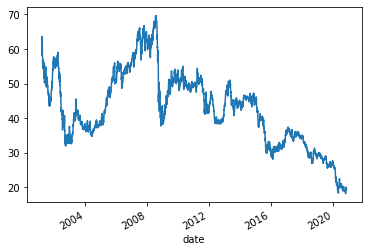

In [ ]:
data_brjp_rev['PX_HIGH'].plot()

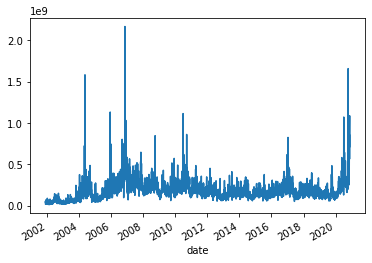

In [ ]:
data_swnw_rev['oseax_vol'].plot()

In [ ]:
test_brjp

,PX_LAST,PX_BID,PX_ASK,PX_MID,PX_LOW,PX_HIGH
date,,,,,,
2018-04-05,32.0950,32.0820,32.1080,32.09500,32.0493,32.4661
2018-04-06,31.7291,31.7180,31.7403,31.72915,31.6227,32.1580
2018-04-09,31.2036,31.1941,31.2130,31.20356,31.1540,31.8280
2018-04-10,31.4328,31.4235,31.4420,31.43277,31.1515,31.5216
2018-04-11,31.6522,31.6430,31.6613,31.65216,31.2091,31.6894
...,...,...,...,...,...,...
2020-11-13,19.1576,19.1439,19.1713,19.15762,18.9394,19.2695
2020-11-16,19.3055,19.2973,19.3136,19.30545,19.1059,19.5513
2020-11-17,19.5510,19.5460,19.5560,19.55100,19.1856,19.5738


In [ ]:
split_date_train_brjp = pd.Timestamp('2018-04-04')
split_date_test_brjp = pd.Timestamp('2018-04-05')
train_brjp = data_brjp_rev.loc[:split_date_train_brjp]
test_brjp = data_brjp_rev.loc[split_date_test_brjp:]

split_date_train_swnw = pd.Timestamp('2018-11-20')
split_date_test_swnw = pd.Timestamp('2018-11-21')
train_swnw = data_swnw_rev.loc[:split_date_train_swnw]
test_swnw = data_swnw_rev.loc[split_date_test_swnw:]

In [ ]:
x_train_brjp = train_brjp[train_brjp.columns[1:]]
y_train_brjp = train_brjp['PX_LAST']
x_test_brjp = test_brjp[test_brjp.columns[1:]]
y_test_brjp = test_brjp['PX_LAST']

x_train_swnw = train_swnw[train_swnw.columns[1:]]
y_train_swnw = train_swnw['PX_LAST']
x_test_swnw = test_swnw[test_swnw.columns[1:]]
y_test_swnw = test_swnw['PX_LAST']

In [ ]:
transformer_x_brjp = MinMaxScaler().fit(x_train_brjp)
transformer_y_brjp = MinMaxScaler().fit(y_train_brjp.values.reshape(-1,1)) 
x_rtrain_brjp = transformer_x_brjp.transform(x_train_brjp)
y_rtrain_brjp = transformer_y_brjp.transform(y_train_brjp.values.reshape(-1,1))
x_rtest_brjp = transformer_x_brjp.transform(x_test_brjp)
y_rtest_brjp = transformer_y_brjp.transform(y_test_brjp.values.reshape(-1,1))

transformer_x_swnw = QuantileTransformer().fit(x_train_swnw)
transformer_y_swnw = QuantileTransformer().fit(y_train_swnw.values.reshape(-1,1)) 
x_rtrain_swnw = transformer_x_swnw.transform(x_train_swnw)
y_rtrain_swnw = transformer_y_swnw.transform(y_train_swnw.values.reshape(-1,1))
x_rtest_swnw = transformer_x_swnw.transform(x_test_swnw)
y_rtest_swnw = transformer_y_swnw.transform(y_test_swnw.values.reshape(-1,1))

In [ ]:
y_rtest_brjp.shape

(685, 1)

In [ ]:
x_tr_t_brjp = x_rtrain_brjp.reshape(x_rtrain_brjp.shape[0], 1, x_rtrain_brjp.shape[1])
x_tst_t_brjp = x_rtest_brjp.reshape(x_rtest_brjp.shape[0], 1, x_rtest_brjp.shape[1])

x_tr_t_swnw = x_rtrain_swnw.reshape(x_rtrain_swnw.shape[0], 1, x_rtrain_swnw.shape[1])
x_tst_t_swnw = x_rtest_swnw.reshape(x_rtest_swnw.shape[0], 1, x_rtest_swnw.shape[1])

In [ ]:
from keras.layers import LSTM
keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
model= Sequential()
model.add(LSTM(128,activation='relu', return_sequences=False, input_shape=(10, x_rtrain_brjp.shape[1])))
#model.add(Dropout(0.2))
#model.add(LSTM(128, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(64, activation='relu',return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
#model.compile(optimizer='adam', loss='rmse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 72,321
Trainable params: 72,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer=opt)
early_stop = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
             ModelCheckpoint(filepath='best_model1.h5', monitor='val_loss', save_best_only=True)]
#sch=LearningRateScheduler(lr_schedule)
history_model_lstm = model.fit(x_tr_t_brjp, y_rtrain_brjp, epochs=100, batch_size=32,verbose=1, validation_split=0.1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
125/125 [==============================] - 1s 6ms/step - loss: 8.0209e-05 - rmse: 0.0090 - val_loss: 2.1533e-05 - val_rmse: 0.0046
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 5.9098e-05 - rmse: 0.0077 - val_loss: 4.2515e-05 - val_rmse: 0.0065
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 4.6317e-05 - rmse: 0.0068 - val_loss: 1.1258e-04 - val_rmse: 0.0106
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 4.0863e-05 - rmse: 0.0064 - val_loss: 1.9833e-04 - val_rmse: 0.0141
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 5.3152e-05 - rmse: 0.0073 - val_loss: 2.1198e-04 - val_rmse: 0.0146
Epoch 6/100
125/125 [==============================] - 1s 5ms/step - loss: 8.1032e-05 - rmse: 0.0090 - val_loss: 1.0242e-04 - val_rmse: 0.0101
Epoch 00006: early stopping


In [ ]:
y_rtest_brjp_hat = model.predict(x_tst_t_brjp, verbose=0)

In [ ]:
mean_squared_error(y_rtest_brjp, y_rtest_brjp_hat, squared=False)

0.021173071804365038

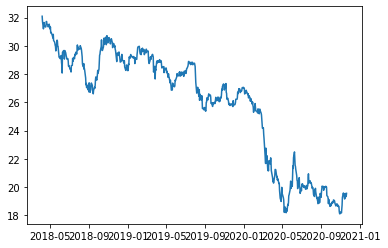

In [ ]:
plt.plot(y_test_brjp)
plt.show()

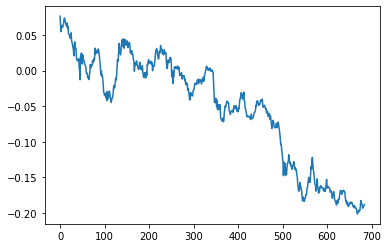

In [ ]:
plt.plot(y_rtest_brjp_hat)
plt.show()

In [ ]:
y_test_brjp_hat=transformer_y_brjp.inverse_transform(y_rtest_brjp_hat)
y_test_brjp_hat_s=y_test_brjp_hat.flatten()

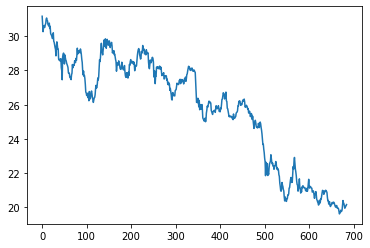

In [ ]:
plt.plot(y_test_brjp_hat_s)
plt.show()

In [ ]:
df_for_comparison_brjp = pd.DataFrame({'actual':y_test_brjp, 'forecast':y_test_brjp_hat_s})

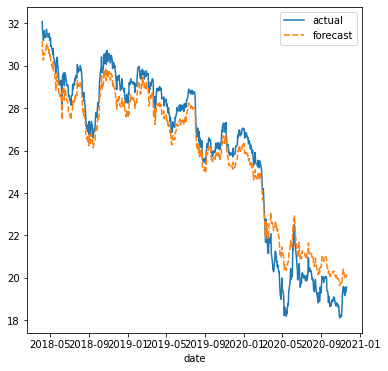

In [ ]:
fig_dims = (6, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=df_for_comparison_brjp,ax=ax)

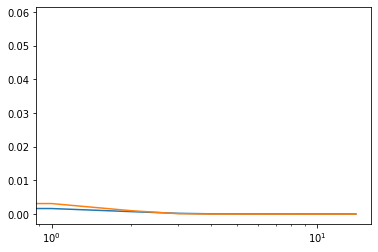

In [ ]:
plt.semilogx(history_model_lstm.history["loss"])
plt.semilogx(history_model_lstm.history['val_loss'])
#plt.axis([1e-8, 1e-4, 0, 60])

**SEKNOK LSTM**

In [ ]:
from keras.layers import LSTM
keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
model= Sequential()
model.add(LSTM(256, activation='relu', return_sequences=False, input_shape=(10, x_rtrain_swnw.shape[1])))
#model.add(Dropout(0.2))
#model.add(LSTM(128, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(64, activation='relu',return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
#model.compile(optimizer='adam', loss='rmse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               275456    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 275,713
Trainable params: 275,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer=opt)
early_stop = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
#sch=LearningRateScheduler(lr_schedule)
history_model_lstm = model.fit(x_tr_t_swnw, y_rtrain_swnw, epochs=100, batch_size=10, verbose=1, validation_split=0.1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
395/395 [==============================] - 2s 5ms/step - loss: 0.0068 - rmse: 0.0823 - val_loss: 2.1394e-05 - val_rmse: 0.0046
Epoch 2/100
395/395 [==============================] - 2s 4ms/step - loss: 0.0049 - rmse: 0.0701 - val_loss: 3.0973e-04 - val_rmse: 0.0176
Epoch 3/100
395/395 [==============================] - 2s 4ms/step - loss: 0.0013 - rmse: 0.0367 - val_loss: 1.4591e-04 - val_rmse: 0.0121
Epoch 4/100
395/395 [==============================] - 2s 4ms/step - loss: 9.0420e-04 - rmse: 0.0301 - val_loss: 1.2732e-04 - val_rmse: 0.0113
Epoch 5/100
395/395 [==============================] - 2s 4ms/step - loss: 6.5828e-04 - rmse: 0.0257 - val_loss: 6.8925e-05 - val_rmse: 0.0083
Epoch 6/100
395/395 [==============================] - 2s 4ms/step - loss: 4.7527e-04 - rmse: 0.0218 - val_loss: 3.1709e-05 - val_rmse: 0.0056
Epoch 00006: early stopping


In [ ]:
y_rtest_swnw_hat = model.predict(x_tst_t_swnw, verbose=0)

In [ ]:
mean_squared_error(y_rtest_swnw, y_rtest_swnw_hat, squared=False)

0.005716168655072442

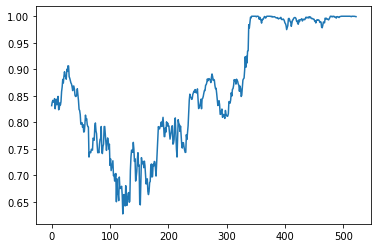

In [ ]:
plt.plot(y_rtest_swnw)
plt.show()

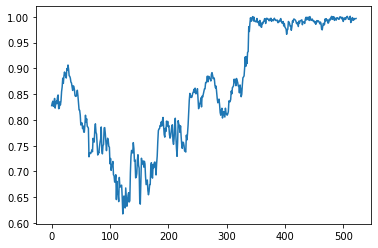

In [ ]:
plt.plot(y_rtest_swnw_hat)
plt.show()

In [ ]:
y_test_swnw_hat=transformer_y_swnw.inverse_transform(y_rtest_swnw_hat)
y_test_swnw_hat_s=y_test_swnw_hat.flatten()

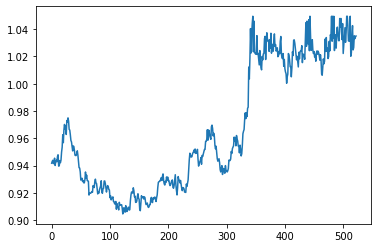

In [ ]:
plt.plot(y_test_swnw_hat_s)
plt.show()

In [ ]:
df_for_comparison_swnw = pd.DataFrame({'actual':y_test_swnw, 'forecast':y_test_swnw_hat_s})

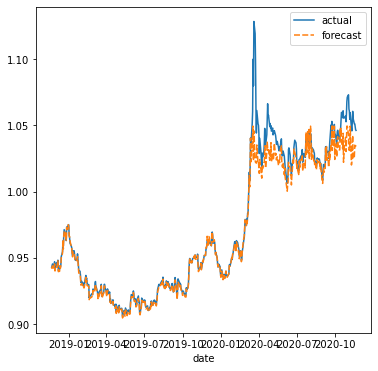

In [ ]:
fig_dims = (6, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=df_for_comparison_swnw,ax=ax)

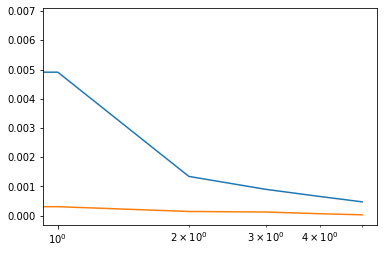

In [ ]:
plt.semilogx(history_model_lstm.history["loss"])
plt.semilogx(history_model_lstm.history['val_loss'])
#plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
model.save("best_model1.h5") 

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
!ls saved_model/my_model

assets	saved_model.pb	variables


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 72,321
Trainable params: 72,321
Non-trainable params: 0
_________________________________________________________________
